In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mplc
import numpy as np
import pandas as pd
import multiprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler

from greenseer.dataset.china_dataset import fetch_train_set, TRAIN_SET_ALL, RELEASE_AT_INDEX_NAME, CODE_INDEX_NAME
from greenseer.models.cash_models import create_cash_debt_relative_search,create_cash_debt_data_prepare_pipeline
from greenseer.plots.boundary_plots import plot_gaussian_mixture_boundaries
from greenseer.plots.normal_plots import DistributeGramEntry, plot_distribute_gram
from greenseer.plots.violin_plots import plot_violin_plot_with_color, ViolinInfos
from greenseer.preprocessing.clean_data import remove_inf_and_na, RemoveAbnormalFilter
from greenseer.preprocessing.transformers import pick_annual_report_china, regular_expression_column_filter, \
    re_percent_column_transform, append_industry_transform, unstack_release_at, \
    append_stock_info_transform,MeanDistanceTransformer
from greenseer.utils.score import compose_classify_score
from greenseer.utils.tools import enable_matplotlib_chinese,DataSaver
%load_ext autoreload
%autoreload 2
%matplotlib inline

enable_matplotlib_chinese()

# 数据说明
- reports: 数据全集
- analysis_reports: 2018年前的年报
- latest_reports: 2019年的年报

In [2]:
data_saver = DataSaver("cash_in_assert_report")
reports = fetch_train_set(TRAIN_SET_ALL)

In [3]:
reports.sort_index(ascending=True,inplace=True)
idx = pd.IndexSlice

analysis_reports = reports.loc[idx[:,:'2018'], :].fillna(0)
latest_reports = reports.loc[idx[:,'2019-12-31'], :].fillna(0)
reports_2019 = reports.loc[idx[:,"2019-10-30":'2019-12-31'], :].fillna(0)

在这里，取得用于分析的基础数据，存储在变量data中。
其中包含了基本的货币资金，短期短款，资产总计，以及他们存在的比值。

In [4]:
subjects = [r'\w*货币资金\w*|\w*短期借款\w*|\w*资产总计\w*|\w*应付利息\w*']
cash_subject_name = 'cash'
st_debt_name = 'short-term debt'
interest_name = 'interest'
distance_name = 'distance_all'

distance_calculate = MeanDistanceTransformer(group_by="industry",
                                             columns=[cash_subject_name, st_debt_name],
                                             new_column=distance_name)
prepare_pipeline = Pipeline([
        ('pick_annual_report', pick_annual_report_china()),
        ('pick_subject', regular_expression_column_filter(patterns=subjects,rename={"资产总计(万元)":"base"})),
        ('percent cache', re_percent_column_transform(numerator=[r'\w*货币资金\w*'], denominator=[r'base'],new_name=cash_subject_name)),
        ('percent receivable', re_percent_column_transform(numerator=[r'\w*短期借款\w*'], denominator=[r'base'],new_name=st_debt_name)),
        ('percent interest', re_percent_column_transform(numerator=[r'\w*应付利息\w*'], denominator=[r'base'],new_name=interest_name)),
        ('append industry',append_industry_transform()),
        ('clean data',remove_inf_and_na()),
        ('remove abnormal',RemoveAbnormalFilter([cash_subject_name, st_debt_name],quantile=0.98,mode="high")),
        ('distance cal',distance_calculate)
])

data = prepare_pipeline.fit_transform(analysis_reports)
data_2019 = prepare_pipeline.transform(reports_2019)
data_all = prepare_pipeline.transform(reports)

这里。打算计算每个年份的所有现金的平均值。有个简单的比较

Saving figure annual_avg_all_fig
Saving scv: ./analysisData/cash_in_assert_report/csv/annual_avg_all_fig.csv


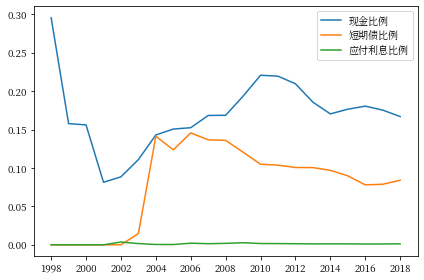

In [5]:
annual_avg_data =data.reset_index().groupby(RELEASE_AT_INDEX_NAME).mean()

plt.plot(annual_avg_data.index.year,annual_avg_data[cash_subject_name],label='现金比例')
plt.plot(annual_avg_data.index.year,annual_avg_data[st_debt_name],label='短期债比例')
plt.plot(annual_avg_data.index.year,annual_avg_data[interest_name],label='应付利息比例')
annual_x_axis = np.array(annual_avg_data.index.year)
plt.legend( loc='upper right')
plt.xticks(annual_x_axis[::2])
data_saver.save_fig("annual_avg_all_fig")
data_saver.save_csv(annual_avg_data,"annual_avg_all_fig")
plt.show()

用高斯分布，用现金比例和短期债，按照行业来进行分类

In [6]:
industry_mean = data.groupby("industry").mean()
X = industry_mean[[cash_subject_name,st_debt_name,distance_name]].values

In [7]:
bic=[]
aic=[]
for i in range(1,11):
    industry_mean_model = GaussianMixture(n_components=2,n_init=10)
    industry_mean_model.fit(X).predict(X)
    bic.append(industry_mean_model.bic(X))
    aic.append(industry_mean_model.aic(X))


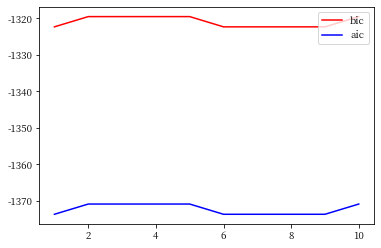

In [8]:
plt.plot(range(1,11),bic,'-r',label='bic')
plt.plot(range(1,11),aic,'-b',label='aic')
plt.legend( loc='upper right')
plt.show()

In [9]:
industry_mean_model = GaussianMixture(n_components=3,n_init=10)
y_pred = industry_mean_model.fit(X).predict(X)
industry_mean["group"] = y_pred
data_saver.save_csv(data=industry_mean,name="industry_mean_group")

Saving scv: ./analysisData/cash_in_assert_report/csv/industry_mean_group.csv


In [10]:
def plot_3d_distribute(data:pd.DataFrame,
                       pax,group_column:str="group",
                       group_number=3,
                       axis_info=[(cash_subject_name,"货币资金"),
                                  (st_debt_name,"短期借款"),
                                  (distance_name,"平均点距离")]):
    norm = plt.Normalize(0, group_number)
    for i in range(0,group_number):
        color = mplc.to_hex(plt.cm.jet(norm(i)))
        industry_mean_group = data[data[group_column]==i]
        pax.scatter(industry_mean_group[axis_info[0][0]], 
                   industry_mean_group[axis_info[1][0]], 
                   industry_mean_group[axis_info[2][0]], 
                   c=color,
                   label="group " + str(i))
    pax.set_xlabel(axis_info[0][1], fontsize=13)
    pax.set_ylabel(axis_info[1][1], fontsize=13)
    pax.set_zlabel(axis_info[2][1], fontsize=13)
    pax.legend()

Saving figure industry_disturibe_with_group


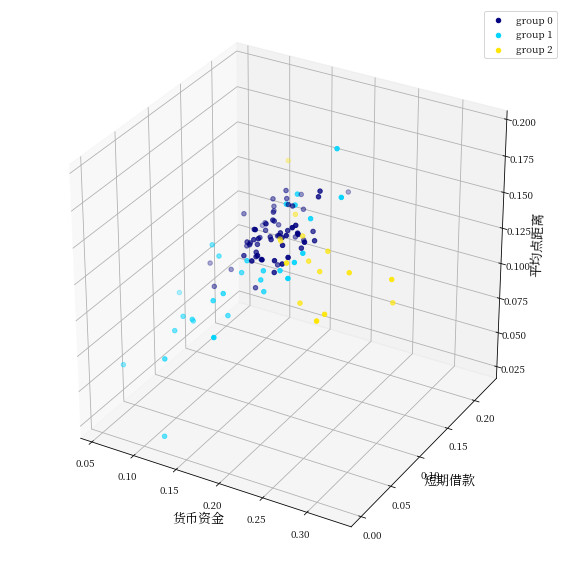

In [11]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
plot_3d_distribute(industry_mean,ax,group_number=3)

data_saver.save_fig("industry_disturibe_with_group")
plt.show()

分布图

Saving scv: ./analysisData/cash_in_assert_report/csv/cash_st_debt_industry.csv
Saving figure cash_st_debt_distribute


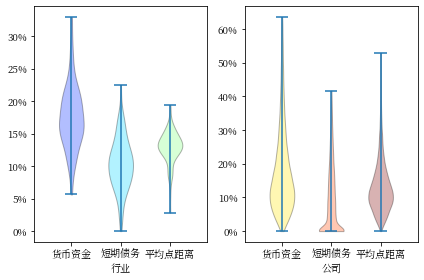

In [12]:
fig, (ax1,ax2)= plt.subplots(1,2)

norm = plt.Normalize(0, 6)

plot_violin_plot_with_color(ax1,
                            industry_mean[[cash_subject_name,st_debt_name,distance_name]].values,
                            "行业",
                            ViolinInfos(["货币资金","短期债务","平均点距离"],
                                        [mplc.to_hex(plt.cm.jet(norm(1))),
                                         mplc.to_hex(plt.cm.jet(norm(2))),
                                         mplc.to_hex(plt.cm.jet(norm(3)))]),
                            y_to_percent=True)
plot_violin_plot_with_color(ax2,
                            data[[cash_subject_name,st_debt_name,distance_name]].values,
                            "公司",
                            ViolinInfos(["货币资金","短期债务","平均点距离"],
                                        [mplc.to_hex(plt.cm.jet(norm(4))),
                                         mplc.to_hex(plt.cm.jet(norm(5))),
                                         mplc.to_hex(plt.cm.jet(norm(6)))]),
                              y_to_percent=True)
data_saver.save_csv(industry_mean,"cash_st_debt_industry")
data_saver.save_fig("cash_st_debt_distribute")
plt.show()

 ## 行业的分布图
根据行业的信息，用高斯来做分类

In [13]:
industry_company_count = data.groupby("industry").count()
company_sum = industry_company_count['base'].sum()
industry_mean["weight"] = industry_company_count['base'].values/company_sum
company_mean_model = GaussianMixture(n_components=3,n_init=10,
                                     means_init=industry_mean[[cash_subject_name,st_debt_name]].values,
                                     weights_init=industry_mean["weight"].values)

Saving figure industry_disturibe_with_weight


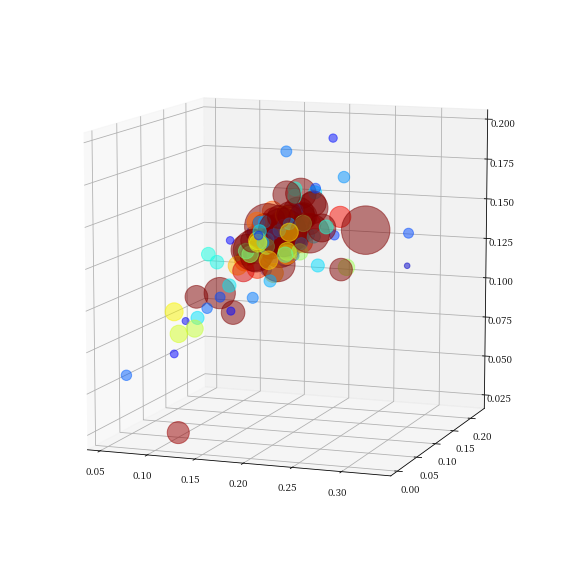

In [14]:

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(industry_mean[cash_subject_name].values,
           industry_mean[st_debt_name].values,
           industry_mean[distance_name], 
           s=industry_mean["weight"].values*50000,
           c=plt.cm.jet(industry_mean["weight"].values*100),
           alpha=0.5)

ax.view_init(10, -70)
data_saver.save_fig("industry_disturibe_with_weight")
plt.show()

## 预测一年新的数据

这里，想要取2017年(包括2017年)的之前五年的数据。然后2018年的数据微target建立预测模型。



In [15]:
cash_2018_data = data.copy()
cash_2018_data.sort_index(ascending=True,inplace=True)


def transform_cash_data(start_year:str,end_year:str,stock_data=cash_2018_data)->pd.DataFrame:
    transformer = unstack_release_at(start=start_year,end=end_year,column_name=cash_subject_name)
    return transformer.transform(stock_data)

cash_2012_to_2017 = transform_cash_data("2012","2017")
cash_2018 = transform_cash_data("2018","2018")



In [16]:
def intersection_by_index(pd1:pd.DataFrame,pd2:pd.DataFrame)->(pd.DataFrame,pd.DataFrame):
    index_1 = pd1.index
    index_2 = pd2.index
    index = index_1.intersection(index_2)
    return pd1.loc[index],pd2.loc[index]
cash_2012_to_2017,cash_2018 = intersection_by_index(cash_2012_to_2017,cash_2018)
X = cash_2012_to_2017.values
y = cash_2018.values
y = y.ravel()

In [17]:
predict_cache_pipeline = Pipeline([
        ('poly_features', PolynomialFeatures()),
        ('model', SGDRegressor(max_iter=10e5))
])

param_grid = [
        {'model__penalty': ['l2', 'l1', 'elasticnet',None],
         'model__learning_rate':['constant','optimal','invscaling','adaptive'],
         'model__eta0':1/10**np.arange(3,6),
         'poly_features__degree':np.arange(1,3)},
  ]
grid_search = GridSearchCV(predict_cache_pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X, y)
grid_search.best_params_

{'model__eta0': 1e-05,
 'model__learning_rate': 'optimal',
 'model__penalty': 'l1',
 'poly_features__degree': 1}

In [18]:
grid_search.best_score_

-0.005509724072336394

In [19]:
cash_2013_to_2018 = transform_cash_data("2013","2018")
cash_2019 = data_2019.reset_index().set_index(CODE_INDEX_NAME)[cash_subject_name].to_frame()
cash_2013_to_2018,cash_2019 = intersection_by_index(cash_2013_to_2018,cash_2019)
len(cash_2013_to_2018),len(cash_2019)

(3341, 3341)

In [20]:
cash_2019_predict = grid_search.predict(cash_2013_to_2018.values)
cash_2019["predict"]=cash_2019_predict
cash_2019["gap"] = cash_2019[cash_subject_name] - cash_2019['predict']

In [21]:
mean_squared_error(cash_2019[cash_subject_name],cash_2019["predict"])

0.004823376242615477

In [22]:
cash_2019_sort_by_gap = cash_2019.sort_values(by=['gap'],ascending=False)

stock_info_pipeline = Pipeline([
    ("stock_name",append_stock_info_transform(index_names=[CODE_INDEX_NAME])),
    ('append industry',append_industry_transform(index_names=[CODE_INDEX_NAME]))])
cash_2019_sort_by_gap = stock_info_pipeline.fit_transform(cash_2019_sort_by_gap)
cash_2019_gap_top5 = cash_2019_sort_by_gap.head(5)
cash_2019_gap_top5

,cash,predict,gap,name,industry
code,,,,,
600186,0.563470,0.037367,0.526104,莲花健康,食品
688181,0.599485,0.125963,0.473522,八亿时空,半导体
603226,0.567957,0.153687,0.414270,菲林格尔,家居用品
600052,0.500895,0.130999,0.369896,浙江广厦,影视音像
600516,0.535371,0.165816,0.369555,方大炭素,矿物制品


In [23]:
cash_2019_gap_tail5 = cash_2019_sort_by_gap.tail(5)
cash_2019_gap_tail5

,cash,predict,gap,name,industry
code,,,,,
002063,0.101241,0.346010,-0.244769,远光软件,软件服务
300578,0.101327,0.407586,-0.306259,会畅通讯,通信设备
002700,0.057738,0.395670,-0.337932,ST浩源,供气供热
300105,0.057766,0.408984,-0.351218,龙源技术,电器仪表
002770,0.007541,0.365140,-0.357599,ST科迪,乳制品


[莲花健康年报](https://vip.stock.finance.sina.com.cn/corp/view/vCB_AllBulletinDetail.php?stockid=600186&id=5993577)

In [24]:
data_all.sort_index(ascending=True,inplace=True)
cash_data_2013_2020 = transform_cash_data("2013","2020",stock_data=data_all)
data_saver.save_csv(cash_data_2013_2020,"cash_data_2013_2020")
abnormal_cash_top_5 = stock_info_pipeline.transform(cash_data_2013_2020.loc[cash_2019_gap_top5.index.values])
abnormal_cash_top_5

Saving scv: ./analysisData/cash_in_assert_report/csv/cash_data_2013_2020.csv


,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00,2018-12-31 00:00:00,2019-12-31 00:00:00,name,industry
code,,,,,,,,,
600186,0.032749,0.030961,0.030483,0.015216,0.008527,0.023078,0.563470,莲花健康,食品
688181,0.113509,0.132544,0.109551,0.111788,0.055974,0.156663,0.599485,八亿时空,半导体
603226,0.136155,0.070231,0.099166,0.145691,0.164739,0.182627,0.567957,菲林格尔,家居用品
600052,0.021609,0.027085,0.012216,0.054033,0.170284,0.154909,0.500895,浙江广厦,影视音像
600516,0.226502,0.265303,0.238933,0.199908,0.115857,0.195730,0.535371,方大炭素,矿物制品


In [25]:
abnormal_cash_tail_5 = stock_info_pipeline.transform(cash_data_2013_2020.loc[cash_2019_gap_tail5.index.values])
abnormal_cash_tail_5

,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00,2018-12-31 00:00:00,2019-12-31 00:00:00,name,industry
code,,,,,,,,,
002063,0.547763,0.556104,0.457967,0.458602,0.422653,0.411776,0.101241,远光软件,软件服务
300578,0.542666,0.482412,0.455768,0.362471,0.472235,0.509336,0.101327,会畅通讯,通信设备
002700,0.469035,0.415133,0.414679,0.455772,0.509920,0.487261,0.057738,ST浩源,供气供热
300105,0.388610,0.295406,0.331325,0.458874,0.476639,0.529366,0.057766,龙源技术,电器仪表
002770,0.106417,0.068922,0.299114,0.387753,0.335090,0.494324,0.007541,ST科迪,乳制品


Saving figure abnormal_cash_curve_top_5


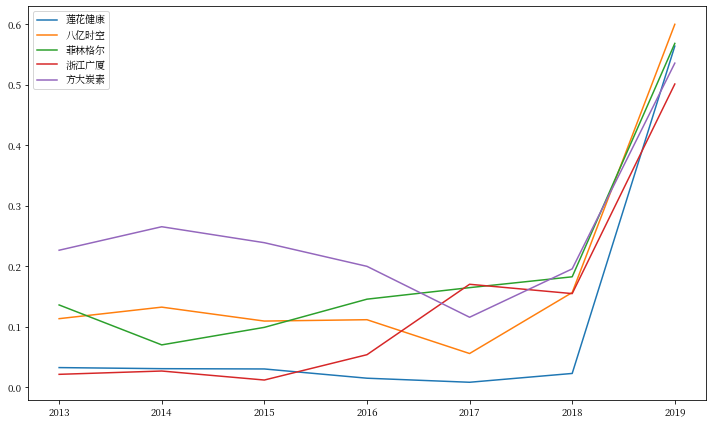

In [26]:
year_2013_to_2019 =  pd.to_datetime(abnormal_cash_top_5.columns[0:7]).year
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
def plot_curve(ax,X_axis,name):
    ax.plot(year_2013_to_2019,X_axis[0:7].values,label=name)
abnormal_cash_top_5.apply(lambda row: plot_curve(ax1,row[0:7],row[7]),axis=1)

ax1.legend(loc='upper left')
data_saver.save_fig("abnormal_cash_curve_top_5")
plt.show()

Saving figure abnormal_cash_curve_tail_5


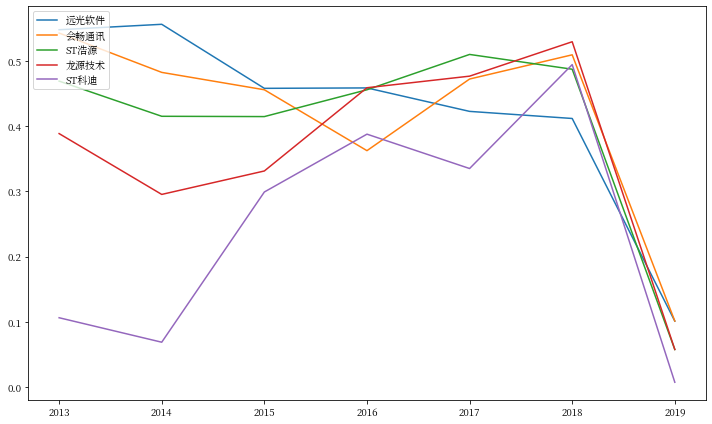

In [27]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111)
abnormal_cash_tail_5.apply(lambda row: plot_curve(ax1,row[0:7],row[7]),axis=1)
ax1.legend(loc='upper left')
data_saver.save_fig("abnormal_cash_curve_tail_5")
plt.show()

## 短期借款和货币资金的对比

根据唐朝的书的说法，货币资金应该和短期借债相匹配。那么，最后匹配的就是，相同行业的企业的公司，应该大致相同。

那么匹配的方式，就是变成了，用2018年以前的数据，建立一个分类模型。然后用这个分类器来猜测2019的数据。如果发觉，最后，这个偏差有点大。那么就认为是异常数据。

In [28]:
data_debt = data.copy()
industry_hot_encoder = OneHotEncoder(sparse=False)

X=data_debt[[cash_subject_name,st_debt_name,distance_name]].values
y=industry_hot_encoder.fit_transform(data_debt[["industry"]].values)
X.shape,y.shape

((39461, 3), (39461, 110))

In [29]:
forest_clf = RandomForestClassifier()
debt_model_pipeline = Pipeline([
    ("standard",StandardScaler()),
    ("model",forest_clf)
])


y_pred = cross_val_predict(debt_model_pipeline, X, y, cv=3,n_jobs=multiprocessing.cpu_count())

In [30]:
compose_classify_score(y,y_pred)

'accuracy 0.08519804363802234,recall is 0.08519804363802234,f1 is 0.14977836188269886'

In [31]:
y_text = industry_hot_encoder.inverse_transform(y)

In [32]:
y_pred_text = industry_hot_encoder.inverse_transform(y_pred)


### 靠行业分类，感觉不太靠谱
主要还是准确率有点低。想想逻辑上也说不过去。靠两个变量，去分100多组，这个有点难为了。

1. 先对行业分组。
2。 用模型，去预测上面的分组。

In [33]:
data_debt = data.copy().reset_index()
industry_group = industry_mean.reset_index()[["industry","group"]]
data_debt_group = pd.merge(data_debt,industry_group,on="industry",how="left")
data_debt_group = data_debt_group.set_index([CODE_INDEX_NAME])
data_debt_group.groupby("group").count()

,releaseAt,应付利息(万元),短期借款(万元),货币资金(万元),base,cash,short-term debt,interest,industry,distance_all
group,,,,,,,,,,
0,25144,25144,25144,25144,25144,25144,25144,25144,25144,25144
1,7812,7812,7812,7812,7812,7812,7812,7812,7812,7812
2,6505,6505,6505,6505,6505,6505,6505,6505,6505,6505


In [34]:
debt_model_pipeline = create_cash_debt_data_prepare_pipeline(industry_group)
X = debt_model_pipeline.fit_transform(data_debt)
industry_group_sparse = industry_hot_encoder.transform(data_debt_group[["industry"]].values)
industry_group_encoder = OneHotEncoder(sparse=False)
y = data_debt_group[["group"]].values
X.shape,y.shape  

((39461, 3), (39461, 1))

In [35]:
debt_by_group_model = data_saver.load_sklearn_model("debt_by_group")
if debt_by_group_model is None:
    debt_by_group_search = create_cash_debt_relative_search(data_debt_group,industry_mean.reset_index())
    debt_by_group_search.fit(X, y)
    debt_by_group_model = debt_by_group_search.best_estimator_
    data_saver.save_sklearn_model(debt_by_group_model,"debt_by_group")
    debt_by_group_search.best_params_

In [36]:
y_pred = debt_by_group_model.predict(X)

In [37]:
y

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [38]:
compose_classify_score(industry_group_encoder.fit_transform(y),y_pred)

'accuracy 0.7767415929652062,recall is 0.8120422695826259,f1 is 0.8154104534581913'

In [39]:
debt_model_pipeline = create_cash_debt_data_prepare_pipeline(industry_group=industry_group)
debt_data_2019 = pd.merge(data_2019.copy().reset_index(),industry_group,on="industry",how="left")
debt_data_2019= debt_data_2019.set_index([CODE_INDEX_NAME])
debt_data_2019.head(5)

,releaseAt,应付利息(万元),短期借款(万元),货币资金(万元),base,cash,short-term debt,interest,industry,distance_all,group
code,,,,,,,,,,,
688599,2019-12-31,0.0,0.0,0.0,3649123.0,0.000000,0.000000,0.000000,电气设备,0.213907,0
688598,2019-12-31,0.0,1559.0,999.0,33692.0,0.029651,0.046272,0.000000,矿物制品,0.131989,0
688588,2019-12-31,0.0,0.0,39189.0,79029.0,0.495881,0.000000,0.000000,软件服务,0.215827,2
688566,2019-12-31,0.0,0.0,0.0,59562.0,0.000000,0.000000,0.000000,化学制药,0.210529,0
688516,2019-12-31,70.0,26652.0,12850.0,137992.0,0.093121,0.193142,0.000507,专用机械,0.146677,0


In [40]:
X_2019 = debt_model_pipeline.fit_transform(data_2019.copy())
y_2019 = industry_group_encoder.fit_transform(debt_data_2019[["group"]].astype(str).values)
industry_group_sparse_2019 = industry_hot_encoder.transform(data_2019.copy()[["industry"]].values)
X_2019.shape,y_2019.shape

((3771, 3), (3771, 3))

In [41]:
y_pred_2019 = debt_by_group_model.predict(X_2019)
debt_data_2019["predict_group"] = industry_group_encoder.inverse_transform(y_pred_2019)
debt_data_2019 = debt_data_2019.astype({"predict_group":int})
debt_data_2019.groupby('predict_group').count()

,releaseAt,应付利息(万元),短期借款(万元),货币资金(万元),base,cash,short-term debt,interest,industry,distance_all,group
predict_group,,,,,,,,,,,
0,2243,2243,2243,2243,2243,2243,2243,2243,2243,2243,2243
1,1396,1396,1396,1396,1396,1396,1396,1396,1396,1396,1396
2,132,132,132,132,132,132,132,132,132,132,132


In [42]:
compose_classify_score(y_2019,y_pred_2019)

'accuracy 0.48448687350835323,recall is 0.543357199681782,f1 is 0.5451642942663296'

In [43]:
X_2019

array([[0.        , 0.        , 0.18389955],
       [0.02965096, 0.04627211, 0.13693634],
       [0.49588126, 0.        , 0.29022385],
       ...,
       [0.09892338, 0.        , 0.1258431 ],
       [0.09607016, 0.008882  , 0.08033366],
       [0.06403288, 0.        , 0.11093182]])

In [44]:
debt_data_2019["distance"]=X_2019[:,2]
debt_data_2019.groupby('group').count()

,releaseAt,应付利息(万元),短期借款(万元),货币资金(万元),base,cash,short-term debt,interest,industry,distance_all,predict_group,distance
group,,,,,,,,,,,,
0,2414,2414,2414,2414,2414,2414,2414,2414,2414,2414,2414,2414
1,695,695,695,695,695,695,695,695,695,695,695,695
2,662,662,662,662,662,662,662,662,662,662,662,662


Saving figure industry_group_disturibute


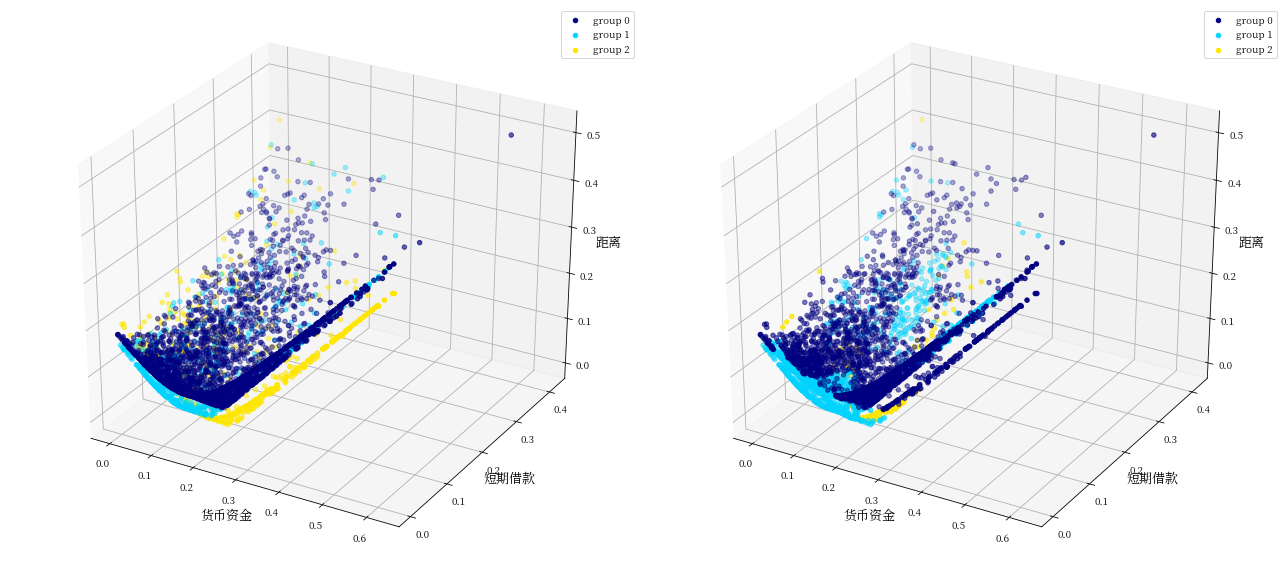

In [72]:
fig = plt.figure(figsize=(18,8))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_3d_distribute(debt_data_2019,
                   ax1,
                   group_number=3,
                   axis_info=[(cash_subject_name,"货币资金"),
                               (st_debt_name,"短期借款"),
                               ("distance","距离")])
plot_3d_distribute(debt_data_2019,
                   ax2,
                   group_column="predict_group",
                   group_number=3,
                   axis_info=[(cash_subject_name,"货币资金"),
                               (st_debt_name,"短期借款"),
                               ("distance","距离")])

data_saver.save_fig("industry_group_disturibute")
plt.show()

In [46]:
from sklearn.metrics import confusion_matrix
conf_mx = confusion_matrix(industry_group_encoder.inverse_transform(y_2019),
                 industry_group_encoder.inverse_transform(y_pred_2019))

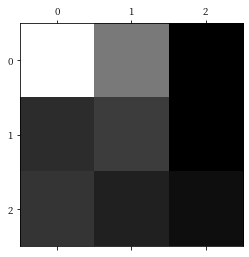

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

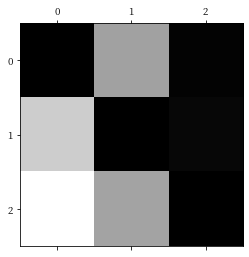

In [48]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [49]:
norm_conf_mx

array([[0.        , 0.32394366, 0.006628  ],
       [0.41294964, 0.        , 0.01582734],
       [0.51359517, 0.32779456, 0.        ]])

In [50]:
row_sums

array([[2414],
       [ 695],
       [ 662]])

In [51]:
def calculate_distance(row: pd.Series, centerids):
    group = row["group"]
    center_ids = centerids[group]
    val = row[[cash_subject_name,st_debt_name,interest_name]].values
    return np.linalg.norm(center_ids - val)

debt_data_2019.head(5)

,releaseAt,应付利息(万元),短期借款(万元),货币资金(万元),base,cash,short-term debt,interest,industry,distance_all,group,predict_group,distance
code,,,,,,,,,,,,,
688599,2019-12-31,0.0,0.0,0.0,3649123.0,0.000000,0.000000,0.000000,电气设备,0.213907,0,0,0.183900
688598,2019-12-31,0.0,1559.0,999.0,33692.0,0.029651,0.046272,0.000000,矿物制品,0.131989,0,0,0.136936
688588,2019-12-31,0.0,0.0,39189.0,79029.0,0.495881,0.000000,0.000000,软件服务,0.215827,2,0,0.290224
688566,2019-12-31,0.0,0.0,0.0,59562.0,0.000000,0.000000,0.000000,化学制药,0.210529,0,0,0.183900
688516,2019-12-31,70.0,26652.0,12850.0,137992.0,0.093121,0.193142,0.000507,专用机械,0.146677,0,0,0.118204


In [52]:
group_centers = industry_mean_model.means_

In [53]:
debt_data_2019["group_distance"]=debt_data_2019.apply(lambda row:calculate_distance(row,group_centers),axis=1)
debt_data_2019.head(5)

,releaseAt,应付利息(万元),短期借款(万元),货币资金(万元),base,cash,short-term debt,interest,industry,distance_all,group,predict_group,distance,group_distance
code,,,,,,,,,,,,,,
688599,2019-12-31,0.0,0.0,0.0,3649123.0,0.000000,0.000000,0.000000,电气设备,0.213907,0,0,0.183900,0.242947
688598,2019-12-31,0.0,1559.0,999.0,33692.0,0.029651,0.046272,0.000000,矿物制品,0.131989,0,0,0.136936,0.202007
688588,2019-12-31,0.0,0.0,39189.0,79029.0,0.495881,0.000000,0.000000,软件服务,0.215827,2,0,0.290224,0.291121
688566,2019-12-31,0.0,0.0,0.0,59562.0,0.000000,0.000000,0.000000,化学制药,0.210529,0,0,0.183900,0.242947
688516,2019-12-31,70.0,26652.0,12850.0,137992.0,0.093121,0.193142,0.000507,专用机械,0.146677,0,0,0.118204,0.161938


In [54]:
debt_abnoraml_100 = debt_data_2019.sort_values(["group_distance"],ascending=False).head(100)
data_saver.save_csv(debt_abnoraml_100,"industry_group_top_100")
debt_abnoraml_100.head(5)

Saving scv: ./analysisData/cash_in_assert_report/csv/industry_group_top_100.csv


,releaseAt,应付利息(万元),短期借款(万元),货币资金(万元),base,cash,short-term debt,interest,industry,distance_all,group,predict_group,distance,group_distance
code,,,,,,,,,,,,,,
600870,2019-12-31,0.0,1604.0,2395.0,4167.0,0.574754,0.384929,0.0,家用电器,0.474525,0,0,0.508184,0.503783
688288,2019-12-31,0.0,501.0,60299.0,96542.0,0.624588,0.005189,0.0,汽车配件,0.485857,0,0,0.475113,0.493994
002968,2019-12-31,0.0,0.0,61759.0,99535.0,0.620475,0.000000,0.0,房产服务,0.468259,0,0,0.472082,0.491448
002625,2019-12-31,0.0,0.0,498982.0,805279.0,0.619639,0.000000,0.0,汽车配件,0.482244,0,0,0.471263,0.490670
300781,2019-12-31,0.0,0.0,43853.0,70863.0,0.618842,0.000000,0.0,广告包装,0.461234,0,0,0.470482,0.489929


Saving figure industry_group_distance_top_100


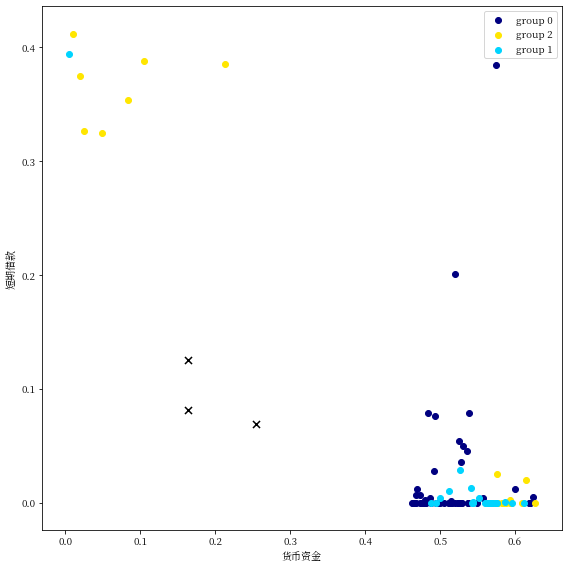

In [55]:
from greenseer.plots.boundary_plots import plot_centroids

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
plot_centroids(ax, group_centers)


groups = debt_data_2019["group"].unique()
norm = plt.Normalize(0, len(groups))
for i in groups:
    color = mplc.to_hex(plt.cm.jet(norm(i)))
    industry_mean_group = debt_abnoraml_100[debt_abnoraml_100["group"]==i]
    ax.scatter(industry_mean_group[cash_subject_name], 
               industry_mean_group[st_debt_name], 
               c=color,
               label="group " + str(i))
ax.legend()
ax.set_xlabel("货币资金")
ax.set_ylabel("短期借款")
data_saver.save_fig("industry_group_distance_top_100")
plt.show()

In [56]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1))

In [57]:
X = debt_model_pipeline.fit_transform(data_debt)

In [58]:
data_debt_forest = data_debt.copy()

In [59]:
X.shape

(39461, 3)

In [60]:
data_debt_forest["abnormal"] = model.fit_predict(X)
len(data_debt_forest.query("abnormal==-1"))/len(data_debt_forest)

0.09999746585236056

In [61]:
data_debt_forest_2019 = data_2019.copy()

In [62]:
X_2019 = debt_model_pipeline.fit_transform(data_2019.copy())
debt_data_2019["abnormal"] = model.predict(X_2019)

In [63]:
data_debt_forest_2019_abnormal = debt_data_2019.query("abnormal==-1")
len(data_debt_forest_2019_abnormal)

255

In [64]:
len(data_debt_forest_2019_abnormal)/len(data_debt_forest_2019)

0.06762132060461416

In [65]:
data_debt_forest_2019_abnormal = data_debt_forest_2019_abnormal.sort_values(["group_distance"])
data_debt_forest_2019_abnormal.head(5)

,releaseAt,应付利息(万元),短期借款(万元),货币资金(万元),base,cash,short-term debt,interest,industry,distance_all,group,predict_group,distance,group_distance,abnormal
code,,,,,,,,,,,,,,,
600759,2019-12-31,43822.0,255765.0,9475.0,1408632.0,0.006726,0.181570,0.031110,石油开采,0.182668,1,0,0.189597,0.207260,-1
002410,2019-12-31,0.0,108862.0,223120.0,616732.0,0.361778,0.176514,0.000000,软件服务,0.132796,2,0,0.192369,0.211554,-1
600781,2019-12-31,17865.0,246336.0,4184.0,1142517.0,0.003662,0.215608,0.015637,中成药,0.228869,0,0,0.196247,0.215996,-1
300807,2019-12-31,0.0,4976.0,38890.0,93400.0,0.416381,0.053276,0.000000,软件服务,0.126898,2,0,0.205155,0.219404,-1
600362,2019-12-31,0.0,4211924.0,2975039.0,13491392.0,0.220514,0.312193,0.000000,铜,0.095748,0,0,0.226742,0.234848,-1
